In [114]:
import nbimporter
import torch
import tiktoken
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from GPT import GPTModel
from text_processor import create_dataloader_v1


In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

def generate_out_tokens(model, idx, context_length, new_tokens):
    for _ in range(new_tokens):
        idx_cond = idx[:, -context_length:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def text_to_token(text, tokenizer):
    tokens = torch.tensor(tokenizer.encode(text, allowed_special={'<|endoftext|>'})).unsqueeze(0)
    return tokens
    

def token_to_text(tokens, tokenizer):
    text = tokenizer.decode(tokens.squeeze(0).tolist())
    return text 

In [137]:
with open("marathi.txt", "r") as file:
    r = file.read() 

data_chars = len(r)
data_token = tokenizer.encode(r)
print(f"total chars: {data_chars}")
print(f"total tokens: {len(data_token)}")

total chars: 20503
total tokens: 32017


In [138]:
split_ratio = 0.85
split_idx = int(data_chars * split_ratio)
train_data = r[:split_idx]
val_data = r[split_idx:]

In [139]:
train_data_loader = create_dataloader_v1(txt=train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=True, drop_last=True, num_workers=0)

val_data_loader = create_dataloader_v1(txt=val_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=True, drop_last=False, num_workers=0)

In [140]:
print("training set:")
for x, y in train_data_loader:
    print(x.shape, y.shape)
print("validation set:")
for x, y in val_data_loader:
    print(x.shape, y.shape)


training set:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [141]:
def cross_entropy(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())

    return loss

def batch_loss(data_loader, model, device, num_batches=None):
    total_loss = 0

    if len(data_loader) == 0:
        return float("nan")
    
    elif num_batches is None:
        num_batches = len(data_loader)

    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = cross_entropy(input_batch, target_batch, model, device)
            total_loss += loss.item()

        else:
            break

    return total_loss / num_batches



In [142]:
device = "mps" if torch.mps.is_available() else "cpu"
gpt = GPTModel(GPT_CONFIG_124M)
gpt.to(device)

with torch.no_grad():
    train_loss = batch_loss(model=gpt, data_loader=train_data_loader, device=device)
    val_loss = batch_loss(model=gpt, device=device, data_loader=val_data_loader)
    print(f"train loss: {train_loss}")
    print(f"val loss: {val_loss}")




train loss: 11.05386752002644
val loss: 11.054836061265734


In [143]:
def sample_batch(model, tokenizer, start_context, device, cfg):
    model.eval()
    context_length = cfg["context_length"]
    tokens = text_to_token(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_out_tokens(model=model, idx=tokens, context_length=context_length, new_tokens=50)
    text = token_to_text(token_ids, tokenizer)
    print(text.replace("/n", " "))
    model.train()


def eval_model(model, train_data_loader, val_data_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = batch_loss(train_data_loader, model, device, num_batches=eval_iter)
        val_loss   = batch_loss(val_data_loader, model, device, num_batches=eval_iter)
        model.train()

    return train_loss, val_loss



In [144]:
def gpt_trainer(model, train_loader, val_loader, optimizer, num_epochs, eval_freq, eval_iter, device, start_context, tokenizer, cfg):
    train_losses, val_losses, track_tokens = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = cross_entropy(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = eval_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens.append(tokens_seen)


                print(f" epoch : {epoch}    step: {global_step}")
                print(f" train loss: {train_loss}   val loss: {val_loss}")


        sample_batch(model, tokenizer, start_context, device, cfg)
    
    return train_losses, val_losses, track_tokens




In [145]:
torch.manual_seed(123)
gpt = GPTModel(GPT_CONFIG_124M)
gpt.to(device)
optimizer = torch.optim.AdamW(gpt.parameters(), weight_decay=0.1, lr=0.0004)
start_context = "मराठी भाषा"
num_epochs = 10

tl, vl, ts = gpt_trainer(model=gpt, train_loader=train_data_loader, val_loader=val_data_loader, optimizer=optimizer, num_epochs=num_epochs, eval_freq=10, eval_iter=5, device=device, start_context=start_context, tokenizer=tokenizer, cfg=GPT_CONFIG_124M)

 epoch : 0    step: 0
 train loss: 6.843650245666504   val loss: 6.876763153076172
 epoch : 0    step: 10
 train loss: 2.726739835739136   val loss: 2.8254490375518797
 epoch : 0    step: 20
 train loss: 2.1602195262908936   val loss: 2.2236523151397707
 epoch : 0    step: 30
 train loss: 1.944844627380371   val loss: 2.2010612726211547
 epoch : 0    step: 40
 train loss: 1.9780524253845215   val loss: 2.010049271583557
 epoch : 0    step: 50
 train loss: 1.9339566230773926   val loss: 2.041202020645142
मराठी भाषाररराररर्रारारररारररारररराररर
 epoch : 1    step: 60
 train loss: 1.9341874361038207   val loss: 2.11297345161438
 epoch : 1    step: 70
 train loss: 1.8797609567642213   val loss: 2.1017468929290772
 epoch : 1    step: 80
 train loss: 1.890576958656311   val loss: 2.05049524307251
 epoch : 1    step: 90
 train loss: 1.9752883195877076   val loss: 2.0335484981536864
 epoch : 1    step: 100
 train loss: 1.9626103401184083   val loss: 1.9953887701034545
मराठी भाषारर्र्री आर्र्री 

In [134]:
def plot_metrics(tokens_seen, train_loss, val_loss, epochs):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs, train_loss, label="training loss")
    ax1.plot(epochs, val_loss, linestyle="-.", label="validation loss")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("losses")
    ax1.legend(loc="upper right")

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_loss, alpha=0)
    ax2.set_xlabel("tokens seen")

    fig.tight_layout()
    plt.figure(dpi=500)
    plt.show()

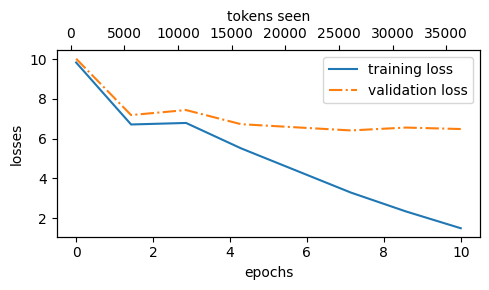

<Figure size 3200x2400 with 0 Axes>

In [135]:
epochs = torch.linspace(0, num_epochs, len(tl))
plot_metrics(ts, tl, vl, epochs)

In [ ]:
'''manual NLL Loss calculation'''
t = text_to_token(start_context, tokenizer)
x = t[:, :-1]
y = t[:, 1:]

logits = gpt(x)
logits = logits.squeeze(0)
target = y.squeeze(0)

loss = torch.nn.functional.cross_entropy(logits, target)
print(loss)

log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
nll = -torch.mean(log_probs[range(target.shape[0]), target])
print(nll)



tensor(10.6147, grad_fn=<NllLossBackward0>)
tensor(10.6147, grad_fn=<NegBackward0>)
